In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(gammapy)

loaded gammapy version: 0.1.dev19174+g56b5bdf 
<module 'gammapy' from '/home/wecapstor1/caph/mppi045h/gammapy/gammapy/__init__.py'>


In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)



In [3]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator, FluxPointsEstimator, FluxPoints

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load 

In [4]:
config = Dataset_load.load_config()
colors = config['colors']['one']

## Read dataset

In [5]:
scaled_amplitude = Parameter('amplitude', 
                             value = 1e-12)
dataset_asimov  = Dataset_load.create_asimov(model = 'pl', source = "PKSflare", 
                                            parameters = Parameters([scaled_amplitude]))


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-pl.fits.gz


## Asimov Cases

In [6]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value


shift_as = 0.1
tilt_as = 0.02
bias_as, resolution_as = 0.1,0.1
bkg_norm_as, bkg_tilt_as = 0.1, 0.02


In [7]:
sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0., 
                        tilt = 0.,
                        bias = 0.,
                        resolution = 0.,
                        bkg_norm = 0., 
                        bkg_tilt = 0., 
                        rnd = False,
                        e_reco_creation=100)
dataset_cor_N = sys_d_cor.create_dataset_N(100)
dataset_cor = sys_d_cor.create_dataset()




zero = 1e-24
    
## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((6, 6))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/bkg_norm_as ** 2, 1/ bkg_tilt_as**2 ,1/bias_as**2, 1/resolution_as**2, 1/shift_as**2, 1/tilt_as**2, ])

dataset_cor_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_cor_N.background_model.parameters['tilt_nuisance'].frozen = False
dataset_cor_N.irf_model.parameters['tilt_nuisance'].frozen = False



In [8]:
%%time
fitting = 0

if fitting:

    print("corr")
    fit_cor = Fit(store_trace=True)
    #minuit_opts = {"tol": 0.001, "strategy": 2}
    #fit_cor.optimize_opts = minuit_opts
    result_cor = fit_cor.run(dataset_cor)
    dataset_cor.models.covariance = fit_cor.covariance(dataset_cor).matrix
    dataset_cor.models.covariance.plot_correlation()
    print(fit_cor.minuit)
    
    path = f'data/2_model.yml'
    dataset_cor.models.write(path,overwrite=True)
    
else:
    print("read")
    path = f'data/2_model.yml'
    dataset_cor = Dataset_load.load_dataset(dataset_cor, path)        
         
    



read
CPU times: user 717 ms, sys: 2.43 s, total: 3.15 s
Wall time: 105 ms


In [9]:
%%time
fitting = 0
#13min 25s

if fitting:

    print("corr")
    fit_cor = Fit(store_trace=True)
    #minuit_opts = {"tol": 0.001, "strategy": 2}
    #fit_cor.optimize_opts = minuit_opts
    result_cor = fit_cor.run(dataset_cor_N)
    dataset_cor_N.models.covariance = fit_cor.covariance(dataset_cor_N).matrix
    dataset_cor_N.models.covariance.plot_correlation()
    print(fit_cor.minuit)
    
    path = f'data/2_model_nui.yml'
    dataset_cor_N.models.write(path,overwrite=True, )
    
else:
    print("read")
    path = f'data/2_model_nui.yml'
    dataset_cor_N = Dataset_load.load_dataset_N(dataset_cor_N, path, bkg_sys = True)        
         
    



read
CPU times: user 88.1 ms, sys: 11.2 ms, total: 99.3 ms
Wall time: 99.6 ms


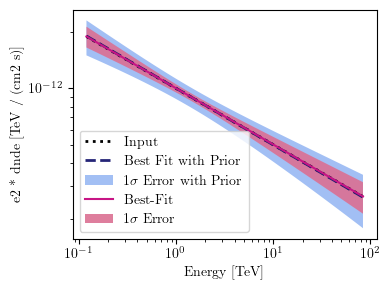

In [10]:
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV

fig,axs = plt.subplots(1,1,figsize = (4,3))
energy_power=2
dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = energy_power, ax =axs, 
                                label = "Input", color = 'black', linewidth = energy_power, linestyle="dotted")
dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = energy_power, ax = axs,color = colors[1],
                                                         label="Best Fit with Prior",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)
dataset_cor_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = energy_power, ax = axs,
                                                       facecolor=colors[3],
                                                         label="$1\sigma$ Error with Prior",
                                                        alpha = 0.6)

dataset_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = energy_power, ax = axs,
                                label = "Best-Fit", color = colors[0])

dataset_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = energy_power, ax = axs,
                                                       facecolor=colors[2],
                                                          alpha = 0.9,
                                                          label= "$1\sigma$ Error"
                                                         )

axs.legend() 
plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_spectrum_comparison.png", dpi = 300)

## Fluxpoints

In [11]:
maski = dataset_asimov.mask.data.sum(axis=2).sum(axis=1) >0
dataset_asimov.geoms['geom'].axes[0].center[maski]

<Quantity [ 0.36517413,  0.48696753,  0.64938163,  0.86596432,  1.15478198,
            1.53992653,  2.05352503,  2.73841963,  3.65174127,  4.86967525,
            6.49381632,  8.65964323, 11.54781985, 15.39926526, 20.53525026,
           27.38419634, 36.51741273, 48.69675252, 64.93816316, 86.59643234] TeV>

In [16]:
energy_edges = dataset_asimov.geoms['geom'].axes[0].edges[::3]
print(energy_edges)
fpe = FluxPointsEstimator(energy_edges=energy_edges,
                         selection_optional = ["errn-errp"])

[1.00000000e-01 2.37137371e-01 5.62341325e-01 1.33352143e+00
 3.16227766e+00 7.49894209e+00 1.77827941e+01 4.21696503e+01
 1.00000000e+02] TeV


In [18]:
%%time
compute = 1
if compute:
    fp = fpe.run(dataset_cor)
    fp.write("data/9_fp.fits", overwrite = True)
else:
    fp = FluxPoints.read("data/9_fp.fits")
fp.to_table()    


0.10000000000000002 TeV 0.23713737056616552 TeV
norm 1.0 0

0.23713737056616552 TeV 0.5623413251903491 TeV
norm 1.0038201173927026 0.13934690423276416

0.5623413251903491 TeV 1.333521432163324 TeV
norm 0.9996354377013149 0.074170747589359

1.333521432163324 TeV 3.1622776601683795 TeV
norm 0.9981496748419194 0.08807284866486066

3.1622776601683795 TeV 7.498942093324559 TeV
norm 0.9977148969740786 0.1265466442918849

7.498942093324559 TeV 17.78279410038923 TeV
norm 0.9971636550784858 0.19243931643890733

17.78279410038923 TeV 42.169650342858226 TeV
norm 0.9962989930941627 0.30080461128204256

42.169650342858226 TeV 100.00000000000004 TeV
norm 1.0402399398859323 0.5431418195850349
CPU times: user 9.26 s, sys: 495 ms, total: 9.75 s
Wall time: 9.77 s


e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool
0.15399265260594924,0.10000000000000002,0.23713737056616552,7.399873464870835e-11,1.0364130223897406e-11,1.5194406250342508e-12,nan,nan,nan,nan,nan,0.0,0.0,True,0.0,False
0.36517412725483767,0.23713737056616552,0.5623413251903491,1.0157221698961999e-11,3.373521633121304e-12,1.1728281253564422e-12,1.0038201173927026,0.13934690423276416,67.63416632707231,8.223999411908558,122784.15428243541,232.17508,121519.37111248635,False,122783.0,True
0.8659643233600653,0.5623413251903491,1.333521432163324,1.394201578332869e-12,1.0980803949082147e-12,9.052843454123779e-13,0.9996354377013149,0.074170747589359,287.7434471596207,16.96300230382643,154210.25345620024,532.2086,221212.49903996516,False,154209.0,True
2.0535250264571463,1.333521432163324,3.1622776601683795,1.913710361588845e-13,3.574248766758758e-13,6.987722483203969e-13,0.9981496748419194,0.08807284866486066,229.58743443823187,15.152142899215011,83324.99876365907,333.3301,219705.12850862995,False,83324.0,True
4.869675251658632,3.1622776601683795,7.498942093324559,2.6267990260287376e-14,1.1634170235544858e-13,5.393693788003353e-13,0.9977148969740786,0.1265466442918849,127.6495839561976,11.298211537946951,36011.73759624765,141.5824,158845.90401770076,False,36011.0,True
11.547819846894583,7.498942093324559,17.78279410038923,3.605599500133754e-15,3.786919319339407e-14,4.163292510352658e-13,0.9971636550784858,0.19243931643890733,68.95664269085682,8.304013649486423,13862.816955054024,49.722603,88046.24383789593,False,13862.0,True
27.384196342643612,17.78279410038923,42.169650342858226,4.949121583549176e-16,1.2326412318922399e-14,3.2135685131607915e-13,0.9962989930941627,0.30080461128204256,40.23483664883679,6.343093618167463,3723.4085003094638,15.665514,33167.57879909449,False,3723.0,True
64.93816315762116,42.169650342858226,100.00000000000004,6.793268206256308e-17,4.012243933482756e-15,2.480494119281496e-13,1.0402399398859323,0.5431418195850349,17.812024109548474,4.220429375021986,631.3101518049644,4.4823895,7692.377864443894,False,631.0,True


In [19]:
%%time
compute_N = 1
if compute_N:
    fp_N = fpe.run(dataset_cor_N)
    fp_N.write("data/9_fp_N.fits", overwrite= True)
else:
    fp_N = FluxPoints.read("data/9_fp_N.fits")


0.10000000000000002 TeV 0.23713737056616552 TeV
norm 1.0 0
norm_nuisance -4.7620667865045054e-07 0.10058613207708739
tilt_nuisance -6.023061375881569e-08 0.017744974238769817
bias 0.0005814995092262237 0.0502637940762969
resolution 0.0023166273097649046 0.09463587903990048
norm_nuisance -4.7620667865045054e-07 0.10058613207708739
tilt_nuisance -6.023061375881569e-08 0.017744974238769817
freeze for error
freeze for error
freeze for error
freeze for error
freeze for error
freeze for error

0.23713737056616552 TeV 0.5623413251903491 TeV
norm 1.0260303840639426 0.18165416982349702
norm_nuisance -4.794375505575649e-07 0.012100148284257182
tilt_nuisance -6.024822663533215e-08 0.014206117917985378
bias 0.003476903786030539 0.033911054224773196
resolution -0.002403406949006514 0.06890394136547243
norm_nuisance -4.7622756292650403e-07 0.10090103588803807
tilt_nuisance -6.022874854679369e-08 0.020014573150357706
freeze for error
freeze for error
freeze for error
freeze for error
freeze for erro

In [72]:
fp_dataset = FluxPointsDataset(data = fp,
                              models = dataset_cor.models[0])

fp_dataset_N = FluxPointsDataset(data = fp_N,
                              models = dataset_cor_N.models[0])

fp_N_s = FluxPoints.read("data/9_fp_N.fits")
from astropy.table import Table

table = fp_N_s.to_table()
table['e_min'] *=1.1
table['e_max'] *=1.1


fp_N_ss = FluxPoints.from_table(table)
fp_N_ss.energy_ref

fp_dataset_N_2 = FluxPointsDataset(data = fp_N_ss, models = dataset_cor_N.models[0])


In [73]:
colors


['mediumvioletred', 'midnightblue', 'palevioletred', 'cornflowerblue']

['midnightblue', 'cornflowerblue']
['mediumvioletred', 'palevioletred']


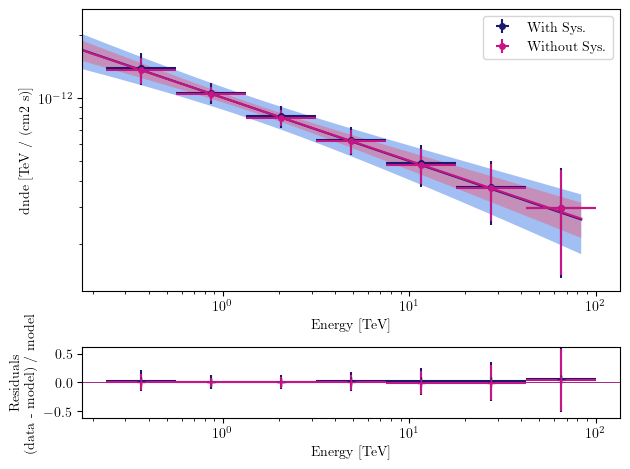

In [77]:
color = 'tab:blue'
energy_power = 2
def plot(fp_dataset, colors_, label,axs=None):
    print(colors_)
    if axs is None:
        fig, (ax1, ax2) = plt.subplots(2,1, height_ratios=(4,1))
    else:
        (ax1, ax2) = axs
    fp_dataset.models[0].spectral_model.plot(energy_bounds = energy_bounds, 
                                            color = colors_[0],
                                            energy_power = energy_power,
                                             ax = ax1,
                                           )


    fp_dataset.models[0].spectral_model.plot_error(energy_bounds = energy_bounds, 
                                            facecolor = colors_[1], 
                                                  alpha = 0.6,
                                                  energy_power = energy_power,
                                                  ax =ax1)
    fp_dataset.data.plot(energy_power=energy_power, color= colors_[0], ax = ax1,
                         label = label)

    fp_dataset.plot_residuals(color = colors_[0],ax = ax2, label = label,
                             method = 'diff/model')
    ax1.set_xlim(ax2.get_xlim()[0], ax2.get_xlim()[1], )
    ax1.legend(); 
    return (ax1, ax2)
ax  = plot(fp_dataset_N, colors_ = [colors[1], colors[3]], label = "With Sys.")
plot(fp_dataset, colors_ = [colors[0], colors[2]], axs=ax , label = "Without Sys.")
plt.tight_layout()
fig = plt.gcf()
fig.savefig('plots/9_flux.pdf')